In [9]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, clean_final_analysis
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004, nu = 0.1,
                    normalize_grads_contx = False, use_context = True, final_analysis = False):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu, normalize_grads_contx = False, use_context = True, freqperc_cutoff = 0.25)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        set_to_deterministic(r_state)
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        DO.problem_type = 'regression'
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"],
                            hyperparameters["normalize_grads_contx"]["value"], hyperparameters["use_context"]["value"], final_analysis)
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()

In [58]:
df1 = pd.read_csv('../data/wine/winequality-red.csv', sep = ";")

df1 = df1[['alcohol', 'volatile acidity', 'total sulfur dioxide', 'citric acid', 'quality']] #

In [59]:
df1.to_csv('../data/wine/red_wine.csv')

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def feature_importance_rf(df: pd.DataFrame, target_col: str):
    """
    Train a Random Forest regression model, print test performance,
    and return the features ordered by importance.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing features and target.
    target_col : str
        The name of the target variable.

    Returns:
    --------
    list
        Feature names ordered by their importance (highest first).
    """

    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions & evaluation
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Model performance on hidden test set:")
    print(f"  R² score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    # Get feature importances
    importance_values = model.feature_importances_
    sorted_indices = np.argsort(importance_values)[::-1]
    sorted_features = X.columns[sorted_indices].tolist()

    return sorted_features


# Call the function
ordered_features = feature_importance_rf(df1, target_col='quality')

print("\nFeatures ordered by importance:")
for i, feat in enumerate(ordered_features, start=1):
    print(f"{i}. {feat}")


Model performance on hidden test set:
  R² score: 0.3013
  RMSE: 0.6757

Features ordered by importance:
1. volatile acidity
2. total sulfur dioxide
3. citric acid


In [29]:
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def best_4_features_with_alcohol(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    
    features = X.columns.tolist()
    
    best_result = None
    
    for combo in itertools.combinations(features, 4):
        if 'alcohol' not in combo:
            continue
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X[list(combo)], y, test_size=0.2, random_state=42
        )
        
        # Fit model with Alcohol
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        r2_with = r2_score(y_test, model.predict(X_test))
        
        # Fit model without Alcohol
        combo_wo_alcohol = [f for f in combo if f != 'alcohol']
        X_train2, X_test2, y_train2, y_test2 = train_test_split(
            X[combo_wo_alcohol], y, test_size=0.2, random_state=42
        )
        model2 = RandomForestRegressor(random_state=42)
        model2.fit(X_train2, y_train2)
        r2_without = r2_score(y_test2, model2.predict(X_test2))
        
        drop = r2_with - r2_without
        
        # Update best set
        if best_result is None or (r2_with > best_result['r2_with'] or 
                                   (r2_with == best_result['r2_with'] and drop > best_result['drop'])):
            best_result = {
                'features': combo,
                'r2_with': r2_with,
                'r2_without': r2_without,
                'drop': drop
            }
    
    return best_result

best_4_features_with_alcohol(df1, "quality")

{'features': ('alcohol',
  'volatile acidity',
  'total sulfur dioxide',
  'citric acid'),
 'r2_with': 0.5073690880019128,
 'r2_without': 0.2887882498078109,
 'drop': 0.2185808381941019}

In [30]:
# 1-2 ; 3-5 ; 6-9 ; 10-50
len(X[X["Frequency"]>=10])/len(X)

0.15641711229946523

<AxesSubplot:>

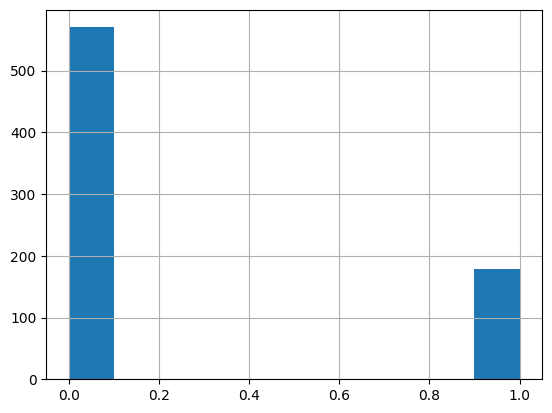

In [57]:
X["Donated_Blood"].hist()

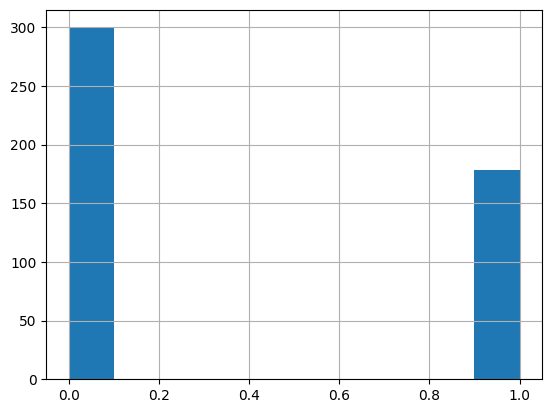

In [84]:
data_path = '../data/donated_blood/donated_blood.csv'
df = pd.read_csv(data_path, index_col = 0)
df_1 = df[df["Donate_Blood"]==1]
df_0 = df[df["Donate_Blood"]==0].sample(n = 300, random_state = 42)
df = pd.concat([df_0, df_1])
df = df.sample(frac = 1, random_state = 42)
df["Donate_Blood"].hist()
df.to_csv('../data/donated_blood/donated_blood_subsampled_balance.csv')

In [38]:
df1.head()

,volatile acidity,total sulfur dioxide,citric acid,quality
0,0.70,34.0,0.00,5
1,0.88,67.0,0.00,5
2,0.76,54.0,0.04,5
3,0.28,60.0,0.56,6
4,0.70,34.0,0.00,5


array([[<AxesSubplot:title={'center':'alcohol'}>]], dtype=object)

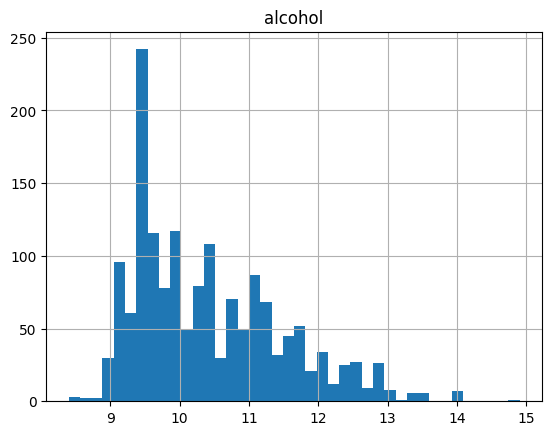

In [48]:
df1[['alcohol']].hist(bins = 40)

In [51]:
print(len(df1[df1['alcohol']<=9.35]))
len(df1[df1['alcohol']<=9.35])/len(df1)

194


0.12132582864290181

In [53]:
len(df1[(df1['alcohol']>9.35) & (df1['alcohol']<=10)])/len(df1)

0.3458411507191995

In [54]:
len(df1[(df1['alcohol']>10) & (df1['alcohol']<=11.5)])/len(df1)

0.3764853033145716

In [55]:
len(df1[df1['alcohol']>=11.5])/len(df1)

0.17510944340212634

In [ ]:
8-9.35 ; 9.35 10; 10-11; 11

In [70]:
df = pd.read_csv('../data/wine/red_wine.csv')

<AxesSubplot:>

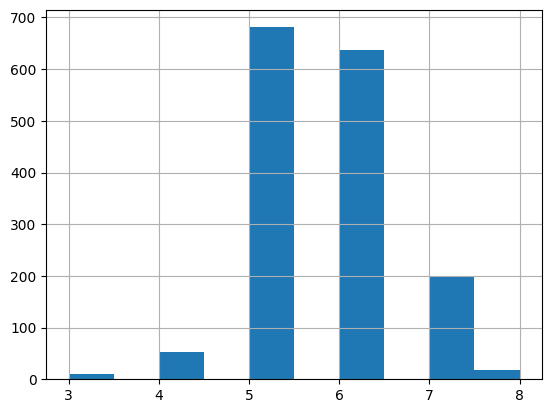

In [73]:
df.quality.hist()

In [2]:
#User requiered data and parameters
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']
hypothesis = [[9.35, 10, 11.5, 15]]

#Percentage of simulated data with full information
partial_perc = 0.25
rand_state = 42

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

In [8]:
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO.problem_type = 'regression'

'multi-class'

False


100%|██████████| 100/100 [23:14<00:00, 13.95s/it]


0.1819249884288776
0.2658789807238917


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


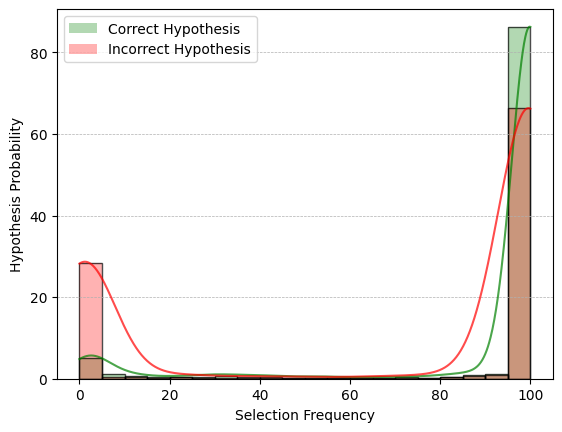

In [3]:
use_info = "use hypothesis"
num_epochs = 100
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")

#though it's a multiclass type of target data, will treat it as regression
DO.problem_type = 'regression'

print(DO.lack_partial_coverage)

DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)


In [4]:
#Number of loops to ensure statistical significance
num_loops = 5
num_epochs = 200
r_state = 0
use_info = "full info"
hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
if not DO.lack_partial_coverage:
    print("Executing...")
    DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                     hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"], False)

Executing...


In [64]:
#Number of loops to ensure statistical significance
num_loops = 5
num_epochs = 200

hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

In [65]:
%%capture

multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

In [10]:
num_loops = 5
num_epochs = 12
hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}
multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:13<02:33, 13.93s/it]

 17%|█▋        | 2/12 [00:27<02:17, 13.79s/it]

 25%|██▌       | 3/12 [00:41<02:04, 13.80s/it]

 33%|███▎      | 4/12 [00:55<01:50, 13.82s/it]

 42%|████▏     | 5/12 [01:09<01:36, 13.82s/it]

 50%|█████     | 6/12 [01:23<01:23, 13.86s/it]

 58%|█████▊    | 7/12 [01:36<01:08, 13.78s/it]

 67%|██████▋   | 8/12 [01:50<00:55, 13.83s/it]

 75%|███████▌  | 9/12 [02:05<00:42, 14.02s/it]

 83%|████████▎ | 10/12 [02:18<00:27, 13.98s/it]

 92%|█████████▏| 11/12 [02:32<00:13, 13.98s/it]

 20%|██        | 1/5 [02:46<11:07, 166.83s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:13<02:29, 13.60s/it]

 17%|█▋        | 2/12 [00:27<02:16, 13.65s/it]

 25%|██▌       | 3/12 [00:40<02:03, 13.67s/it]

 33%|███▎      | 4/12 [00:54<01:50, 13.77s/it]

 42%|████▏     | 5/12 [01:08<01:36, 13.79s/it]

 50%|█████     | 6/12 [01:22<01:23, 13.86s/it]

 58%|█████▊    

In [11]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "")
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

StopIteration: 

In [5]:
%%capture

for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization", "Hyperimpute", "TabPFN"]: #, "Midas"
    counter = 0
    use_info = "use imputation" 
    num_epochs = 400
    for r_state in range(300):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO, lr = 0.004)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break
            

In [6]:
#partial 8%
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Deep Regressor,0.021994,0.006158
1,Hyperimpute,0.014798,0.003372
2,Iterative MICE Imputer,0.017025,0.002185
3,KNN Imputer,0.015783,0.002854
4,Matrix Factorization,0.028538,0.002555
5,Miss Forest,0.013798,0.003545
6,Soft Impute,0.028846,0.002594
7,TabPFN,0.010166,0.002840


In [7]:
#partial 8%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "TabPFN") #
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.828043,0.005827,0.056247
1,partial info,0.528283,0.015641,0.095204
2,use hypothesis,0.742764,0.008592,0.071962
3,use imputation,0.737578,0.008739,0.068960
4,use known only,0.623568,0.012632,0.088167
